In [1]:
import theano.tensor as T
from theano import function

def mean(x, axis=None, keepdims=False):
    return T.mean(x, axis=axis, keepdims=keepdims)

def l2_normalize(x, axis):
    norm = T.sqrt(T.sum(T.square(x), axis=axis, keepdims=True))
    return x / norm

def cosine_similarity(y_true, y_pred):
    assert y_true.ndim == 2
    assert y_pred.ndim == 2
    y_true = l2_normalize(y_true, axis=1)
    y_pred = l2_normalize(y_pred, axis=1)
    return T.sum(y_true * y_pred, axis=1, keepdims=False)

def cosine_ranking_loss(y_true, y_pred):
    MARGIN = 0.01
    
    q = y_pred[0::3]
    a_correct = y_pred[1::3]
    a_incorrect = y_pred[2::3]

    return mean(T.maximum(0., MARGIN - cosine_similarity(q, a_correct) + cosine_similarity(q, a_incorrect)) - y_true[0]*0, axis=-1)

- y_true[0]*0 is an ugly hack to bypass UnusedInputError (i.e you cannot set on_unused_input='ignore' in model.compile)

### Test cosine_similarity

In [2]:
x = T.dmatrix('x')
y = T.dmatrix('y')
z = cosine_similarity(x, y)
f = function([x, y], z)

In [3]:
y = [[1, 0], [1, 0], [3, 4], [1.2, -3.2]]
preds = [[1, 0], [0, 1], [3, 4], [1.3, 2.2]]

f(y, preds)

array([ 1.        ,  0.        ,  1.        , -0.62748384])

In [4]:
from scipy import spatial

for i in xrange(len(y)):
    print 1.0 - spatial.distance.cosine(y[i], preds[i])

1.0
0.0
1.0
-0.627483841199


### Test cosine ranking loss

In [5]:
x = T.dmatrix('x')
y = T.dmatrix('y')
z = cosine_ranking_loss(x, y)
#f = function([x, y], z, on_unused_input='ignore')
f = function([x, y], z)

In [6]:
preds = [[1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0]]
y = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 1], [3, 4]]

f(y, preds)

array(0.505)

In [7]:
(0 + 1.01)/2

0.505

### Test ranking loss on minimal example

In [8]:
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Merge, TimeDistributedMerge
from keras.layers import recurrent
from keras.models import Sequential
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

import numpy as np

Using Theano backend.


In [9]:
print "Creating data..."

data = []
for i in xrange(1000):
    q0 = np.random.choice(range(10))
    q1 = np.random.choice(range(10))
    q = str(q0) + "+" + str(q1)
    a_correct = str(q0 + q1)
    a_incorrect = str(np.random.choice(range(19)))
    data.append(q)
    data.append(a_correct)
    data.append(a_incorrect)

Creating data...


In [10]:
print "Sample data:"
for i in xrange(3):
    print data[i]

Sample data:
7+4
11
8


In [11]:
print "Tokenizing data..."
tokenizer = Tokenizer(filters='', lower=False)
char_data = [' '.join(list(x)) for x in data]
tokenizer.fit_on_texts(char_data)

print "Converting text to sequences..."
data_seq = tokenizer.texts_to_sequences(char_data)

Tokenizing data...
Converting text to sequences...


In [12]:
print "Sample sequences:"
for i in xrange(3):
    print data_seq[i]

Sample sequences:
[3, 2, 10]
[1, 1]
[9]


In [13]:
data_maxlen = max([len(q) for q in data_seq])
print "Questions maxlen:", data_maxlen

print "Padding sequences..."
data_seq_pad = pad_sequences(data_seq, maxlen=data_maxlen) 

print "Sample padded sequences:"
for i in xrange(3):
    print data_seq_pad[i]


Questions maxlen: 3
Padding sequences...
Sample padded sequences:
[ 3  2 10]
[0 1 1]
[0 0 9]


In [14]:
print "Creating model..."

vocab_size = len(tokenizer.word_index) + 1
embed_size = 5
hidden_size = 10
timesteps = data_maxlen
RNN = recurrent.LSTM

print "Vocab_size: ", vocab_size
print "Timesteps: ", timesteps

model = Sequential()
model.add(Embedding(vocab_size, embed_size, mask_zero=True))
model.add(RNN(hidden_size, return_sequences=False))

Creating model...
Vocab_size:  12
Timesteps:  3


In [15]:
model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 12)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Embedding (Unnamed)           (None, None, 5)               60                  
LSTM (Unnamed)                (None, 10)                    640                 
--------------------------------------------------------------------------------
Total params: 700
--------------------------------------------------------------------------------


In [16]:
print "Compiling model..."
model.compile(optimizer="adam", loss=cosine_ranking_loss)

Compiling model...


C:\Users\Tanel\Anaconda\lib\site-packages\theano\scan_module\scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [17]:
_ = [0 for i in xrange(len(data_seq_pad))]
model.fit(data_seq_pad, _, batch_size=6, nb_epoch=10, shuffle=False, validation_split=0.0)

Epoch 1/10
3000/3000 [==============================] - 2s - loss: 0.0278     
Epoch 2/10
3000/3000 [==============================] - 2s - loss: 0.0076     
Epoch 3/10
3000/3000 [==============================] - 2s - loss: 0.0054     
Epoch 4/10
3000/3000 [==============================] - 2s - loss: 0.0039     
Epoch 5/10
3000/3000 [==============================] - 3s - loss: 0.0033     
Epoch 6/10
3000/3000 [==============================] - 3s - loss: 0.0029     
Epoch 7/10
3000/3000 [==============================] - 3s - loss: 0.0026     
Epoch 8/10
3000/3000 [==============================] - 3s - loss: 0.0023     
Epoch 9/10
3000/3000 [==============================] - 3s - loss: 0.0022     
Epoch 10/10
3000/3000 [==============================] - 3s - loss: 0.0021     


In [20]:
test_seq = tokenizer.texts_to_sequences(['4 + 0', '4', '6'])
test_seq_pad = pad_sequences(test_seq, maxlen=data_maxlen)

out = model.predict(test_seq_pad, batch_size=3, verbose=0)
print 1.0 - spatial.distance.cosine(out[0], out[1])
print 1.0 - spatial.distance.cosine(out[0], out[2])

0.986593294744
0.975802469769


### Visualize embeddings

In [21]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#model_dr = TSNE(n_components=2, random_state=0)
model_dr = PCA(n_components=2)

train_out = model.predict(data_seq_pad[:100], batch_size=10, verbose=0)
X_dr = model_dr.fit_transform(train_out)

In [22]:
model_dr.explained_variance_ratio_

array([ 0.91468415,  0.03166569])

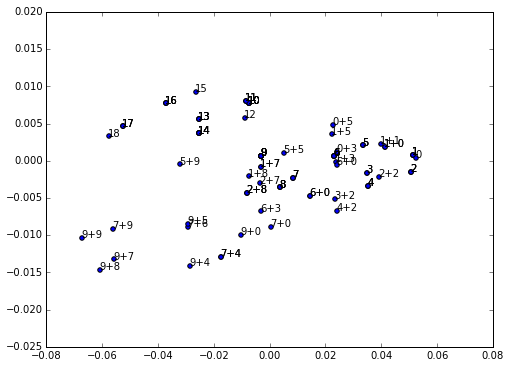

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_dr[:, 0], X_dr[:, 1])

for i, txt in enumerate(data[:100]):
    ax.annotate(txt, (X_dr[i, 0], X_dr[i, 1]))